In [31]:
import pandas as pd
import numpy as np
import copy
import functools
import itertools
import numpy as np
from itertools import product
from functools import partial
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import warnings
warnings.filterwarnings('ignore')

from CI import compute_V

### Figure 3

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
import pandas as pd
import numpy as np

In [3]:
df = pd.read_table('../data/cholesterol.txt', sep = ' ')
X0 = df['compliance'].values.reshape((-1,1))
y0 = df['cholesterol.decrease'].values
df.head()

,compliance,cholesterol.decrease
0,-2.2510,11.50
1,-2.2510,-6.25
2,-2.2510,-7.25
3,-2.2510,-5.25
4,-1.8312,-23.00


In [4]:
def figure_3(n_estimators, random_seed):
    np.random.seed(random_seed)
    sigma = 22.0
    B = n_estimators
    random_seed = 0
    degrees = range(1, 7)
    Cp = list()
    for degree in degrees:
        X = PolynomialFeatures(degree).fit_transform(X0)  
        bagging = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=B, random_state=random_seed)
        bagging.fit(X, y0)
        Cp.append(np.linalg.norm(bagging.predict(X) - y0)**2 + 2*sigma**2*degree)
        
    degree = degrees[np.argmin(Cp)]
    X = PolynomialFeatures(degree).fit_transform(X0)
    bagging = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=B, random_state=random_seed)
    bagging.fit(X, y0)
    V_J, V_J_U, V_IJ, V_IJ_U = compute_V(bagging, X, X)
    return V_J[0], V_J_U[0], V_IJ[0], V_IJ_U[0]

In [9]:
collection_source.shape

(400, 4)

In [5]:
%%time
n_process = 10
n_parallel = 100
random_seeds = list(range(n_parallel))
baggings = [200, 500, 1000, 2000]
with Pool(processes = n_process) as pool:
    collection_source = pool.starmap(figure_3, product(baggings, random_seeds))

collection_source = np.array(collection_source)

CPU times: user 519 ms, sys: 320 ms, total: 839 ms
Wall time: 11min 16s


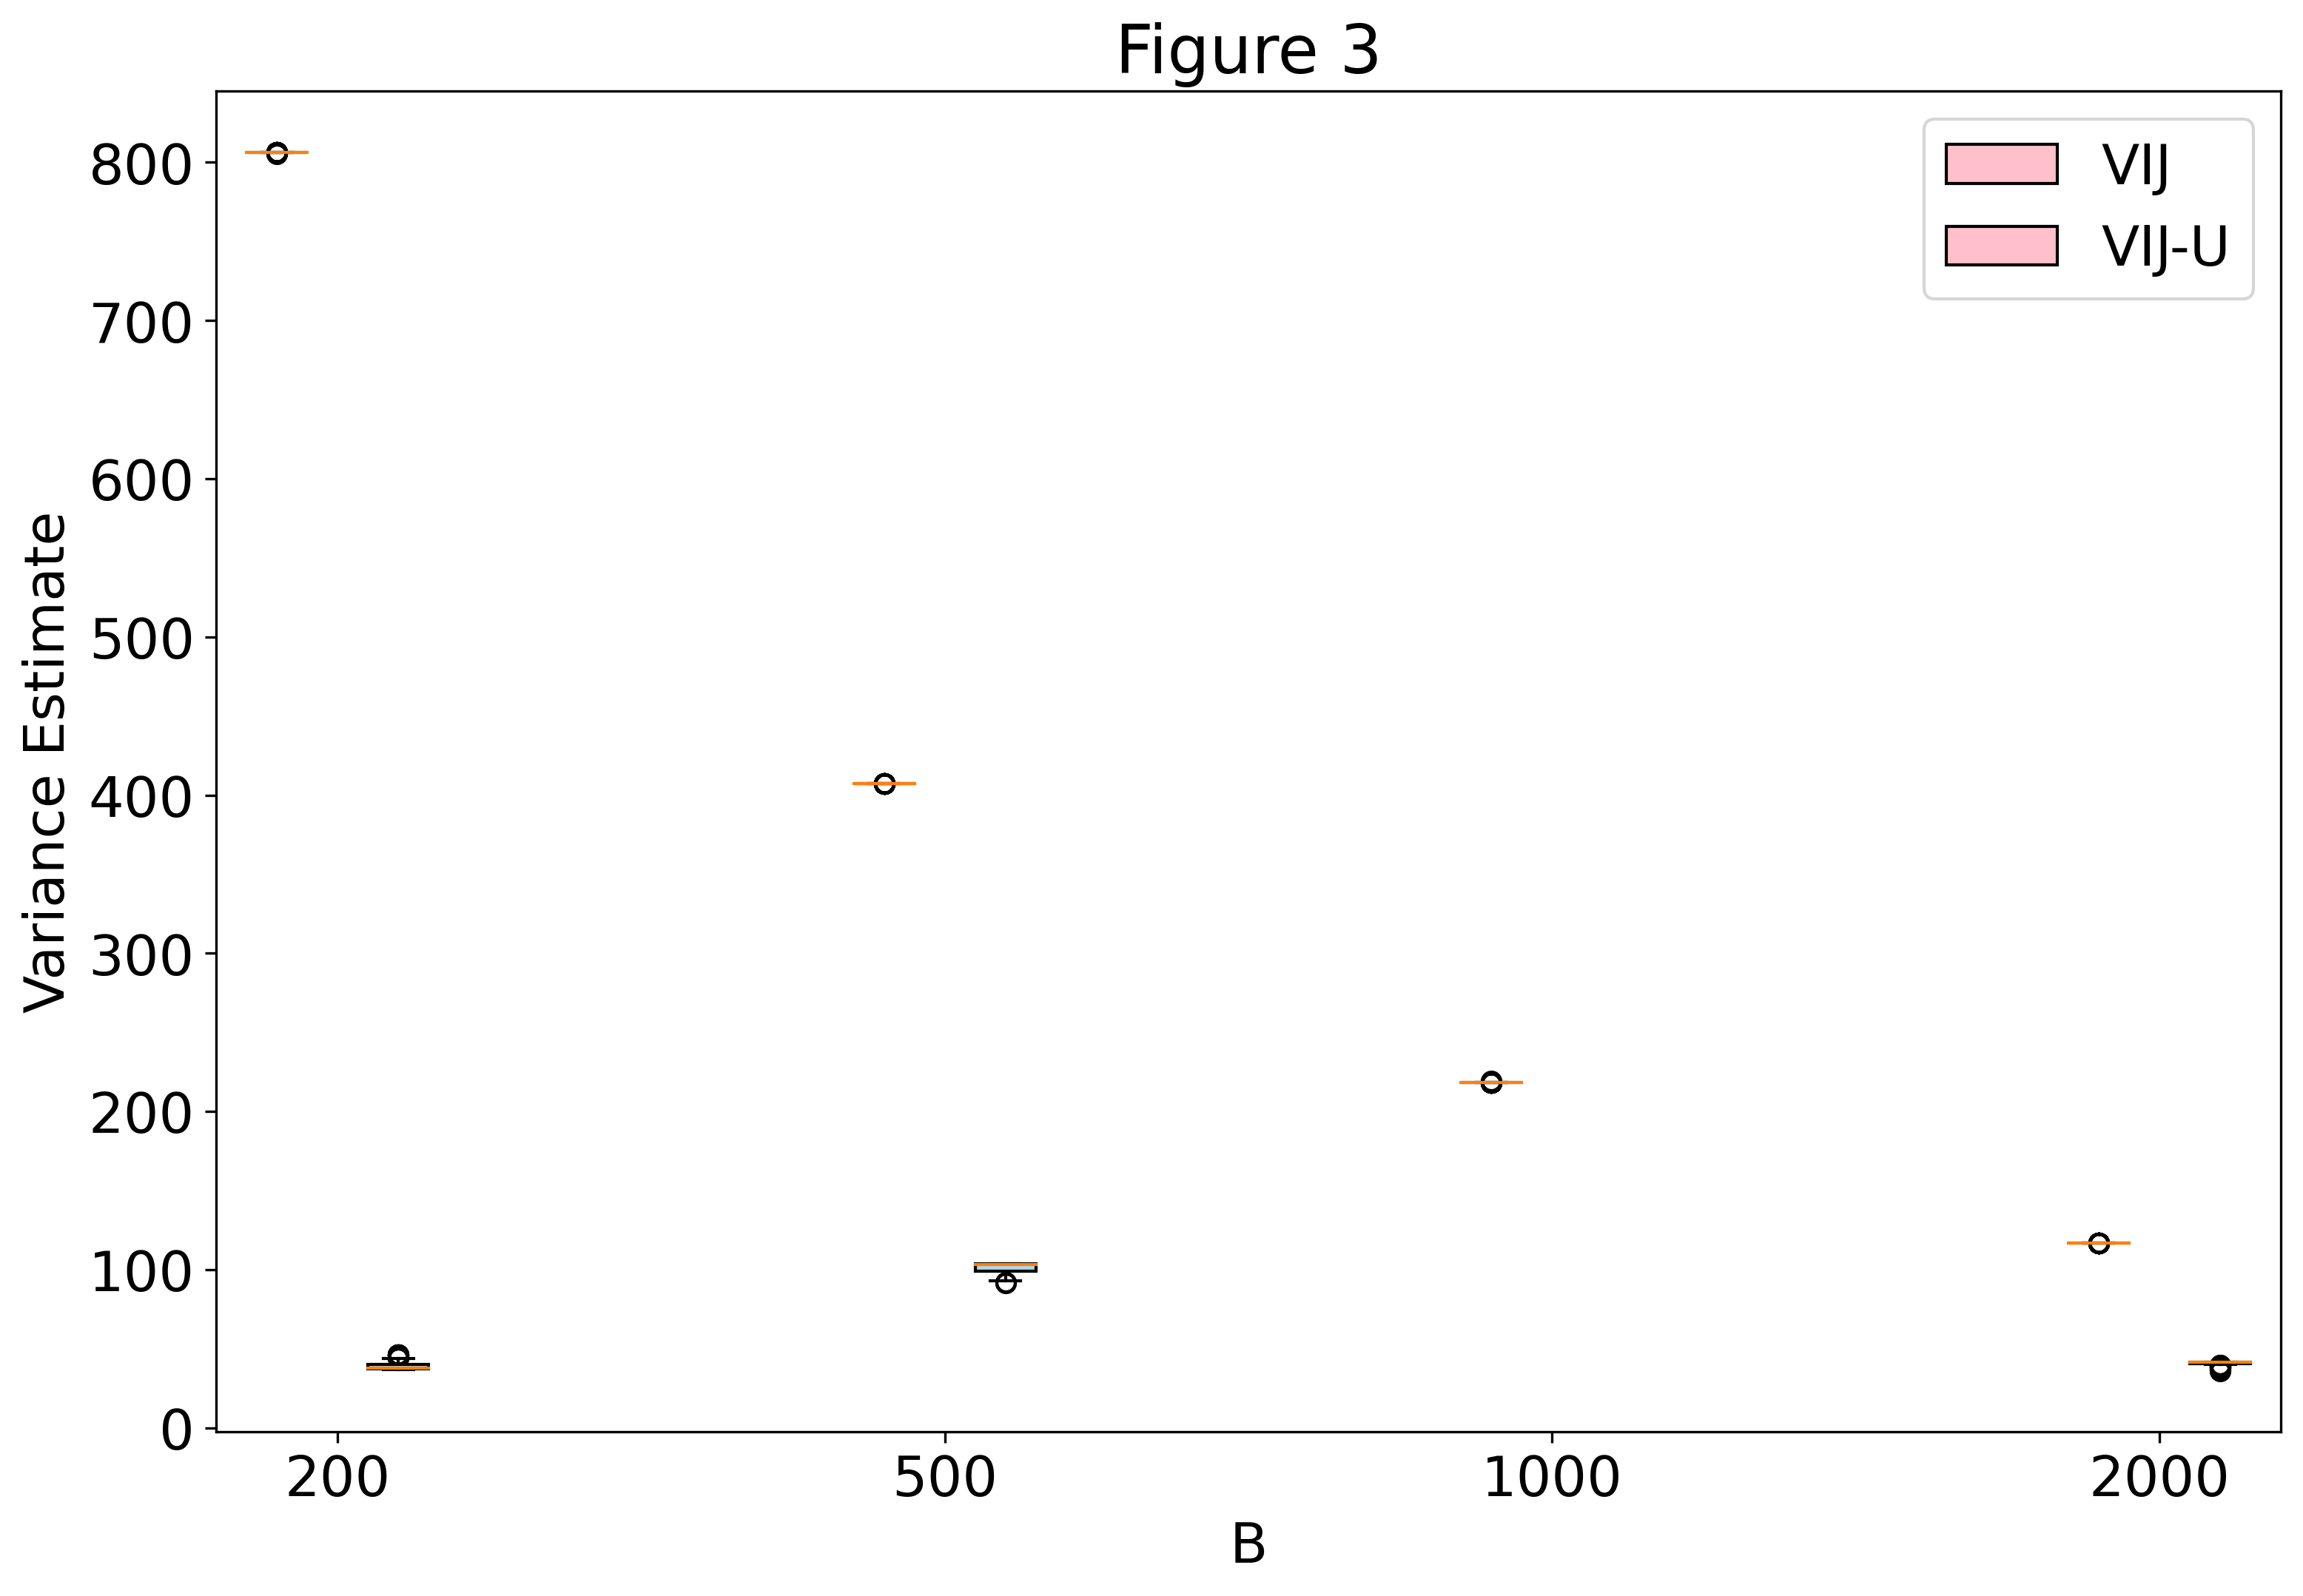

In [32]:
xoffset = 5
inoffset = 1
n_knive = 4
fig1, ax1 = plt.subplots(figsize = (12, 8), dpi = 300)
ax1.set_title('Figure 3')
boxs = list()
legends = ['VIJ', 'VIJ-U']
for k in range(2, n_knive):
    boxs.append(ax1.boxplot([collection_source[i*n_parallel:(i+1)*n_parallel, k] for i in range(len(baggings))],
                                                    positions = [xoffset*i+inoffset*k for i in range(len(baggings))], patch_artist=True))
colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow']
for i in range(n_knive - 2):
    for j in range(len(baggings)):
        boxs[i]['boxes'][j].set_facecolor(colors[i])
    
offsets = [np.mean([xoffset*i+inoffset*k for k in range(2, n_knive)]) for i in range(len(baggings))]
labels = ['200', '500', '1000', '2000']
ax1.legend([boxs[0]["boxes"][0], boxs[0]["boxes"][0]], ['VIJ', 'VIJ-U'], loc='upper right')
plt.xticks(offsets, labels, rotation='horizontal')
plt.xlabel('B')
plt.ylabel('Variance Estimate')
plt.savefig('../figures/figure_3.pdf', dpi = 300)
plt.show()